In [1]:
import numpy as np
import math
import scipy.optimize as opt
import matplotlib.pyplot as plt
import scipy.integrate as intx

R = 8.314 #J/mol-K


#### SUSU TO-DO

- chemcad:
     - heat capcity of iB_B mix
     - heat capacity of air

- heat exchanger -> hot air to heat reaction mixture

- design + resize vessels

- design pumps, compressors, etc
- chemcad: calc heat of reaction
- design heating control

- design tower....
- economics 

#### QUESTIONS
- is nitrogen considered in the gas holdup
- gas hold up recs
    - r_o * B = kla (co* - co)
- pressure recs : .3
- was iB recycle/flow incorrect



#### PART 1: STOICHIOMETRY + MASS BALANCE

In this presentation, we design a CSTR capable of producing 25.2 $ \frac {ktonnes}{year} $ of butyric acid (BA) from a stream of butyraldehyde (B) and isobutyraldehyde (iB). The balanced reactions governing our process are

$ B + \frac{1}{2} O_2 \rightarrow BA $, $r_1 = k_1 C_{O2} C_B$

$ iB + \frac{1}{2} O_2 \rightarrow iBA$, $r_2 = k_2 C_{O2} C_{BA}$

The rate constants are functions of temperature, and are calculated with the Arrhenius equation, 

$k = A \cdot exp[\frac{-Ea}{RT}]$

$Ea_1 = 108.4 \frac{kJ}{mol}$, $Ea_2 = 103.2 \frac{kJ}{mol}$

$A_1 = 3.8e13 \frac{m^3}{mol\cdot min}$, $A_2 = 2.9e13 \frac{m^3}{mol\cdot min}$




In [2]:
molar_flow_per_hour = 25.2 * 1000 * 1000 / 351 / 88.11 / 24 #ktonnes / yr -> kmol/hr
molar_flow_per_hour

33.951344812768035

Running a plant with 2 weeks of downtime, we convert the annual production to a hourly flow rate of $33.95 \frac{kmol}{hr}$ of butryic acid. We will target $36 \frac{kmol}{hr}$ to account for shortfalls in production.

In [68]:
MW = 72.11 #kg/kmol

B_n_dot = 36 #kmol/hr
iB_n_dot = 36/11.8

B_m_dot = B_n_dot / MW #kg/hr
iB_m_dot = iB_n_dot / MW

total_mass_flow = B_m_dot + iB_m_dot
total_mass_flow

density_mix = (11.8 * 800 + 790) / 12.8

v_liq = total_mass_flow / density_mix

print(f"""
Mass flow: {total_mass_flow:.4g} kg/hr
Density: {density_mix:.4g} kg/m3
Liquid volumetric flow: {v_liq:.4g} m3/hr
      """)


Mass flow: 0.5415 kg/hr
Density: 799.2 kg/m3
Liquid volumetric flow: 0.0006776 m3/hr
      


In [87]:
h = 0.3
v_gas = v_liq * h /(1-h) ##m3/hr
excess = 50
O2_n_dot = excess * B_n_dot / 2 / 1000 ## mol/hr
air_n_dot = O2_n_dot / .2 ## mol/hr

p = (air_n_dot * R * (50 + 273.15) / v_gas) / 10e5
p, air_n_dot, v_gas, O2_n_dot
print(f"Pressure = {p:.4g} Bar ")

Pressure = 41.63 Bar 


In [88]:
p = 54 #bar

Doing basic stoichiometric calculations, we find the liquid volumetric flow to be 0.6776 L/hr. We target 30% gas holdup in the reactor. Rearranging the holdup equation, we can solve for the volumetric flow of gas:

$H = \frac{V_g}{V_g + V_l} \rightarrow$
$V_g = \frac {H}{1-H} V_l$

We solve for a volumetric flow rate of 0.29 L/hr. If we want to flow oxygen at 50 times molar excess of the limiting reactant that requires 900 kmol/hr of oxygen. Since air is 20% oxygen, this is 4500 kmol/hr of air. Since we want to run the reaction at 50C, we can backsolve the required pressure to achieve this holdup. The pressure required is 41.63 bar. The air is supplied at 6 bar. Using two compression stages, we can raise the pressure to a maximum of 54 bar. Therefore, we will target this maximum pressure using two compressors.

#### Part 2: Reaction kinetics + Concentrations

In [4]:
 #function that calculates rate constants(m3/mol/s), with temp (C) as input

def k1(T): # m3/mol/s
    A = 3.8e13 / 60 # m3/mol/min -> m3/mol/s
    Ea = 108.4 * 1000 #j/mol
    return A * math.exp(-1 * Ea / (R  * (T + 273.15))) 

def k2(T): # m3/mol/s
    A = 2.9e13 / 60 # m3/mol/min 0 > m3/mol/s
    Ea = 103.2 * 1000 #j/mol
    return A * math.exp(-1 * Ea / (R * (T + 273.15))) 

k1(50)

1.9010669350849042e-06

Oxygen is barely soluble in liquid. The saturated concentration of oxygen, the theoretical maximum that can be dissolved in the liquid is a function of pressure and temperature, and is calculated with Henry's law: $ C_{O_2}^* = H_{O2} P_{O2}$. The Henry's law constant, $H_{O2}$, is temperature dependent. 

The actual concentration of oxygen can then be adjusted to a target fraction of the saturated concentration based on the gas flow rate. 

Since the reactor operates at steady state and oxygen is to be supplied in excess, we will treat the dissolved concentration of oxygen as constant and model the reactions as pseudo-first order with respect to the limiting reactants, B and iB:

$r_1 = k_1' C_B$

$r_2 = k_2' C_{iB}$


#### [TO-DO ] Part 4: Compressors

In [3]:
#max compression ratio = 3
#p1 = 6 barg
#T1 = 20C? -> 293K
#gamma = 1.4 for air
#Tf = 50C -> 
gamma = 1.4
Ti = 20
Pi = 6
Pf = 6*3

def T_final(Pi, Ti, Pf):
    
    return ((Ti + 273) * ((Pf / Pi) ** ((gamma-1)/gamma))) - 273


T_final(6, 15, 18), T_final(18, 121,54)

(121.19657471295403, 266.28281401702736)

Design a series of HEX + compressors -> heat liq stream, cool air stream

Calc if heat duty is reasonable -> 
- chemcad delH of mixture
- mathy math -> del H to pressure

In [117]:
 #function that calculates saturated oxygen concentration (mol/m3), with temp (C) and pressure (atm) as inputs
def C_O2(T,P):
    H0_star = 8.82 #mmol/L/atm
    T0 = 28 + 273.15 #K
    T_in_K = T + 273.15
    P0 = P * .19 #atm - partial pressure of oxygen
    del_H = -12.5 * 1000 #J/mol

    H0 = H0_star * math.exp( -1 * del_H * ((1/T_in_K) - (1/T0))/R) #mmol/L/atm -> same unites as Ho*
    C0 = P0 * H0 #mmol/L OR mol/m3
    return C0 #mol/m3

C_O2(50, 54) #this will calculate saturated oxygen concentration at 50 C and 20 atm


64.41759790815313

In order to maximise the rate of the reaction, we will operate at as high a pressure and temperature as we can. The maximum temp is 50C. The saturated oxygen concentration at 50C and 54atm is $64 \frac{mol}{m^3}$. We decide to target 75% of the saturated oxygen concentration, so from here on we will work with constant oxygen concentration of $48.0 \frac{mol}{m^3}$

In [115]:
C_o = C_O2(50, 54) * .75 #this will calculate a target oxygen concentration of 0.75 * saturated oxygen concentration at 50 C and 20 atm
C_o

48.31319843111484

The total mass flow rate is the sum of the mass flow of B and iB. The volumetric flow rate can be calculated using the average density of the mixture which is 799 $ \frac {kg}{m^3}$.

The concentration of each component can be calulated using $Ci = \frac {F_{i0}}{V_0}$


In [118]:
V_dot = (35 * 12.8 / 11.8) * 77.11 / density_mix #kmols/hr * kg/kmol * m3/kg -> m3/hr 

conc_B = 35 / V_dot #kmol/m3
conc_iB = 35 / 11.8 / V_dot
conc_B, conc_iB

(9.554918754457917, 0.8097388774964336)

the concentrations of B and iB are 9.55 and 0.81 M respectively. 

For a CSTR, $r_i = \frac {C_i - C_{i0}}{\tau}$. Therefore, for our process:

$r_B = \frac {C_B - C_{B0}}{\tau}$

$r_{iB} = \frac {C_{iB} - C_{iB0}}{\tau}$

Setting these equal to the previous pseudo-rate law equations, we obtain:

$k_1' C_B = \frac {C_B - C_{B0}}{\tau}$

$k_2' C_iB = \frac {C_{iB} - C_{iB0}}{\tau}$

We can solve this system of equations for different residence times using python to obtain conversion. As a reminder, $k'_i = k_i \cdot C_{O2}$, where $k$ is dependent on temperature, and the concentration of oxygen is assumed constant and dependent on temperature, pressure and gas flow. [GAS FLOW??]

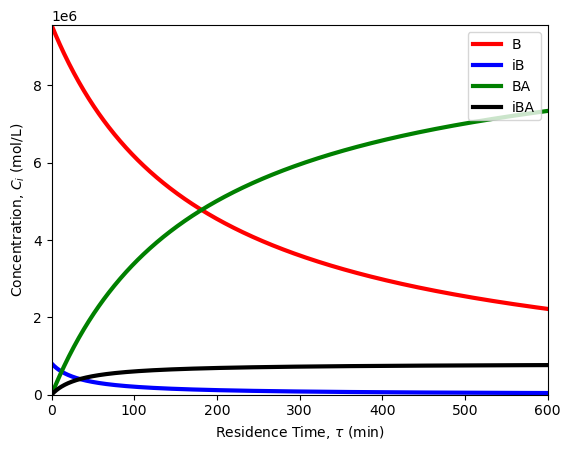

In [119]:
# stoichiometry
# this code sets the stoichometry of the reactions
reaction_1 = [-1, 0,  1,  0] # one mole of B consumed, one mole of BA produced
reaction_2 = [ 0, -1, 0,  1] # one mole of iB consumed, one mole of iBA produced
stoichiometry = np.array([reaction_1, reaction_2])

k = np.array([k1(50), k2(50)]) # calculates the rate constants for temp 50C, m3/mol/s
k_prime = k * C_o #calculates the psedo rate constants,  m3/mol/s * mol/m3 = /s

# # feed conditions
C0 = np.array([conc_B, conc_iB,0,0]) * 1000 # mol/m^3

# # reactor parameters
tMax = 10 * 60 * 60 # max residence time, units: seconds
XBMax = 0.95

def rxns(Ci,ti):
    C_B,C_iB,C_BA,C_iBA = Ci #unpacks the concentrations
   
    r_gen = np.array([ #this code writes the rate of generation/consumption for each component based on the rate constant and the reactant concentration
    -k_prime[0]*C_B,
    -k_prime[1]*C_iB,
     k_prime[0]*C_B,
     k_prime[1]*C_iB
    ]) # /s * mol/m3 = mol/m3*s
    
    res = (Ci-C0)/ti - r_gen #this code sets the rate law equal to the CST design equation
    return res

# independent variable
nPts = 600
t = np.linspace(0,tMax,nPts)

# solve the eqns
C = np.zeros((4,nPts))
C[:,0] = C0
for i,ti in enumerate(t):
    if i == 0:
        continue
    C[:,i] = opt.root(rxns,C[:,i-1],ti).x
CA,CB,CC,CD = C

s_to_min = 1/60
m3_to_L = 1/1000

# plot the results
# plt.figure(figsize=(5,4),dpi=300)
plt.plot(t*s_to_min,CA/m3_to_L,'r-',lw=3,label='B')
plt.plot(t*s_to_min,CB/m3_to_L,'b-',lw=3,label='iB')
plt.plot(t*s_to_min,CC/m3_to_L,'g-',lw=3,label='BA')
plt.plot(t*s_to_min,CD/m3_to_L,'k-',lw=3,label='iBA')
plt.xlabel(r'Residence Time, $\tau$ (min)')
plt.xlim(0,tMax*s_to_min)
plt.ylabel('Concentration, $C_i$ (mol/L)')
plt.ylim(0,np.max(C)/m3_to_L)
plt.legend(loc='upper right')



We can plot conversion of B versus residence time using the change in concentration.

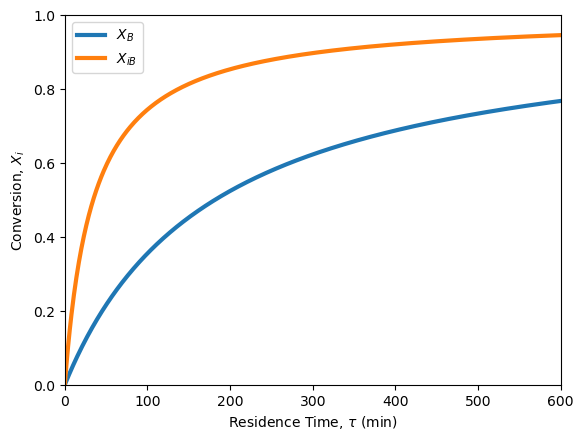

In [95]:
conversion_B = 1 - (CA / CA[0])
conversion_iB = 1 - (CB / CB[0])


# plot the results
# plt.figure(figsize=(5,4),dpi=300)
plt.plot(t*s_to_min,conversion_B,lw=3,label='$X_B$')
plt.plot(t*s_to_min,conversion_iB,lw=3,label='$X_{iB}$')

plt.xlabel(r'Residence Time, $\tau$ (min)')
plt.xlim(0,tMax*s_to_min)
plt.ylabel('Conversion, $X_i$')
plt.ylim(0,1)
plt.legend()
# plt.savefig(pngFile % 'conversion')


Based on our data, we can see that the reaction has a low conversion. 

Our design will proceed with 2 CSTRS in parallel.

We decide on a residence time of 300 minutes. The single pass conversion of B and iB are 0.62 and 0.90 respectively. 

The recycle of the limiting reactant is calcuated using the equation:

$R_B = \frac{F_{B0}(1 - X_B)}{X_B} $

The total flow of B to the reactor can then be calculated as the sum of fresh flow to the reactor and the recycle stream. The total flow of iB to the reactor is the sum of the fresh feed, which is in a molar ratio of 11.8 : 1 with B, and the unreacted iB that will be recycled with the B. We decided to recycle the unreacted iB since there is so little, it will have a neglible effect on the total reaction. The recycle of iB can be calculated similarly to B, using

 $R_{iB} = \frac{F_{iB0}(1 - X_{iB})}{X_{iB}} $

In [122]:
xB, xiB = conversion_B[300], conversion_iB[300]

fresh_B = 35/2 #kmol/hr
fresh_iB = fresh_B / 11.8
recycle_B = fresh_B * (1-xB)/ xB #kmol/hr
recycle_iB = fresh_iB * (1-xiB) / xiB

total_B_inlet = recycle_B + fresh_B

total_inlet = fresh_B + fresh_iB + recycle_iB + recycle_B
total_inlet

fresh_B + recycle_B,fresh_iB + recycle_iB


(np.float64(28.067637751810434), np.float64(1.652450418171394))

In [121]:
xB, xiB

(np.float64(0.6234938670202556), np.float64(0.8974858374865946))

The total molar flow of both B and iB entering each reactor is 40.72 $ \frac {kmol}{hr} $. 

The volumetric flow rate of the reactants, $\dot{V}$, can be calculated using the equation related volumtric flow to molar flow and concentration: $\dot{V} = \frac {F_0}{C_0}$. The concentration of both components can be assumed to be equal to the concentration of B since they are chemically similar.

Then using the equation 
$\tau = \frac {V}{\dot{V}}$, the reactor volume can be calculated from the residence time.




Our reactor volume is 24.5 $m^3$. To size the reactors, we set the diameter to the maximum of $2m$. The height can be calculated using $V = \frac{\pi}{4} \cdot H D^2$.

We calculate a height of 7.8 $m$. Setting the height of the reactor to the maximum of 10 $ m $, we get a overhead of 22%.

In [12]:

tau = 400 / 60 #hr

V = tau * V_dot

H_R = V * 4 / math.pi / (2**2)
V, H_R
# V_dot

(24.420232063665633, 7.773201288767163)

 To summarize our results so far, we will flow a mixture of  35 $\frac{kmol}{hr}$ of butyraldehyde, and 2.96 $\frac{kmol}{hr}$ of isobutryaldehyde, split into two equal streams, into two identical CSTRS operating in parallel. The liquid height will be 7.8m, the reactor height 10m and the diameter 2m with an overhead of 22%. The flow rate of oxygen will be adjusted to target a concentration of 75% of the saturated oxygen concentration.
 
 The reactors will operate at 50C to maximise the rate constants, and increase the rate of reaction, and be pressurised to 15 atm to increase the partial pressure, and therefore the concentration of oxygen in solution.

The reaction is catalyzed by 0.1 wt% manganese acetate. The total mass flow into the reactor is 2.936 $ \frac{tonnes}{hr}$ of mixture, meaning the reactor will require 2.93 $ \frac{kg}{hr}$ of manganese acetate. The catalyst will be introduced into solution before the mixture enters the reactor tank.


The concentration of oxygen can be related to the overall mass transfer rate. $W_O = k_La V (C_o^* - C_o)$ At steady state, the rate of mass transfer of oxygen from gas to liquid will equal the rate of consumption of oxygen at the catalyst site. We targeted a concentration of oxygen in solution of 0.75 of the saturation concentration. 

$W_O = -r_O \cdot V = 0.5 (k_1C_BC_o + k_2C_{iB}C_O)$

we can rearrange and rewrite these equations to:

$0.5 (k_1C_BC_O + k_2C_{iB}C_O) = k_La (C_o^* - C_o)$

$k_La = \frac  {0.5 \cdot 0.75 \cdot C_O^* (k_1C_B + k_2C_{iB})}  {C_O^*(1 - 0.75)}$

$k_La = 1.5  (k_1C_B + k_2C_{iB})$


In [13]:
kla = 1.5 * (k1(50) * conc_B + k2(50) * conc_iB)
kla 

mol_Air = (350/.19) #mols

# pv = nrt
# v/t = nr/p
v_gas = mol_Air * 8.314 / 20  / 3600#m3/s

70 #kmol/hr
35 * 10 - 2*(((total_B_inlet * xB )+ (fresh_iB + recycle_iB) * xiB))

V_dot / 60#->m3/
v_gas * 60 /( (V_dot / 60) + (v_gas * 60 ))

0.995239264214966

In [14]:

V_dot / 60

0.061050580159164085

We get a kLa of 4.58 e-5 $s^-$

In [15]:
print(
f"""

All flow rates in kmol/hr 
Into reactor 
    Fresh Inlet B: {35:0.2f}
    Fresh Inlet iB: {35/11.8:0.2f}

    Recycle B: {recycle_B:0.2f}
    Recycle iB: {recycle_iB:0.2f}
 Total to each reactor: {(35 * 12.8/11.8)/2 + recycle_iB + recycle_B :0.2f}
 total to both reactors: {total_inlet * 2 : 0.2f}
    
Outlets
Out of one reactor
    B: {total_B_inlet * (1-xB):0.2f}
    iB: {(fresh_iB + recycle_iB) * (1-xiB):0.2f}
    BA: {total_B_inlet * xB:0.2f}
    iBA: {(fresh_iB + recycle_iB) * xiB:0.2f}
    
Out of both reactors
    B: {2*total_B_inlet * (1-xB):0.2f}
    iB: {2*(fresh_iB + recycle_iB) * (1-xiB):0.2f}
    BA: {2*total_B_inlet * xB:0.2f}
    iBA: {2*(fresh_iB + recycle_iB) * xiB:0.2f}
 
 BA out: {35}
 iBA out: {2.97}
 """   
)



All flow rates in kmol/hr 
Into reactor 
    Fresh Inlet B: 35.00
    Fresh Inlet iB: 2.97

    Recycle B: 4.28
    Recycle iB: 0.07
 Total to each reactor: 23.33
 total to both reactors:  46.66
    
Outlets
Out of one reactor
    B: 4.28
    iB: 0.07
    BA: 17.50
    iBA: 1.48
    
Out of both reactors
    B: 8.56
    iB: 0.14
    BA: 35.00
    iBA: 2.97
 
 BA out: 35
 iBA out: 2.97
 


##### Section X: CHEMCAD

Using ChemCad, and the pseudo-first order reaction coefficients, we can calculate approximate heat duties.

In [112]:
print(f"""
 K1 at 50C :    {k1(50):.4g}
 K2 at 50C :     {k2(50):.4g}
 
 K1' at 50C :    {k1(50) * C_O2(50, 50):.4g} mol/min
 K2' at 50C :     {k2(50) * C_O2(50, 50):.4g} mol/min
 
 Concentration of B: {conc_B:.4g} mol/m3
 Concentration of iB: {conc_iB:.4g} mol/m3
 
      """)


 K1 at 50C :    1.901e-06
 K2 at 50C :     1.005e-05
 
 K1' at 50C :    0.0001134 mol/min
 K2' at 50C :     0.0005995 mol/min
 
 Concentration of B: 9.555 mol/m3
 Concentration of iB: 0.8097 mol/m3
 
      
